In [38]:
import numpy as np
#get aminoacid conversions from https://raw.githubusercontent.com/zhanxw/anno/master/codon.txt 
dict_aa = {}
with open('codon.txt', 'r') as f: 
    for line in f: 
        if not line.startswith('#'):
            s = line.strip().split('\t')
           
            dict_aa[s[0]] = s[2] 
            

#read in relative adaptive values from https://www.biologicscorp.com/tools/CAICalculator/ 
rel_weights = {} 
with open('yeast_rel_adapt_adj.txt', 'r') as f: 
    for line in f:  
        s = line.strip().split('\t')
        rel_weights[s[0]] = float(s[4])  
        
#define stop codons: 
stop_codons = []
for k in dict_aa.keys(): 
    if dict_aa[k] == 'O':
        stop_codons.append(k)

#read in elongation rates
elongate_dic = {}
with open('elongationrate.csv', 'r') as f: 
    for line in f:
        s = line.strip().split(';')
        elongate_dic[s[2]] = 1/(float(s[3]) / 10)
       
        
def get_codon_occurences(sequence): 
    codon_dict = {}

    
    #iterate through sequence in 3's to grab new codon
    i = 0
    while (i+3) < len(sequence):
        
        codon = sequence[i:i + 3]
       
        #increment frequency of codon appearances by one
      
        if codon not in codon_dict.keys():
            codon_dict[codon] = 1
        else:
            codon_dict[codon] += 1
        i += 3
        
    return codon_dict
    

def adj_for_stop(sequence): 
    i = 0
    while (i+3) < len(sequence):
        
        codon = sequence[i:i + 3]
       
        #increment frequency of codon appearances by one
        if codon in stop_codons: 
            return sequence[:i]
        
        i += 3 
    return sequence
    

#method to calc CAI
def calc_cai_cost(genomic_seq): 
    codon_freq = get_codon_occurences(genomic_seq)
    precai = 0 
    cost = 0 
    for k in codon_freq.keys():
        precai += codon_freq[k]*np.log(rel_weights[k])
        cost += codon_freq[k] * elongate_dic[k] 

    return np.exp(precai / (len(genomic_seq) /3)), cost

#method to combine potentials with a set buffer
def get_regions(pots):
    sort = sorted(pots)
    all_regions = []
    
    curset = []
    
    for i in range(1,len(sort)):
       
        cur = sort[i]
        prev = sort[i-1]
        curset.append(prev)
        if cur - prev <= buffer:
            
            curset.append(cur)
          
        else: 
            if len(curset) > 1: 
                all_regions.append([np.min(curset)- buffer, np.max(curset) + buffer])
                
            curset = []
    if len(curset) > 1: 
        all_regions.append([np.min(curset), np.max(curset)]) 
      
    
     
                
    return all_regions

fastaFile = 'yeast_gencode_all_exons_pcs_IDs_1L_filt.fa'
sequences = {} 
with open(fastaFile, 'r') as g: 
    for line in g: 
        l = line.strip()
        if l.startswith('>'):
            info = l.split(':')
            gene_name = info[-1]
        else: 
            raw_seq = l.upper()
            if 1470 < len(raw_seq) < 1530: 
                sequences[gene_name] = adj_for_stop(raw_seq)


id2prfloc = {}
with open('prfdb_S228C_all_nupack_unique_DNA_filtered_for_all.tsv','r') as f: 
    for line in f: 
        s = line.strip().split()
        info = int(s[1])
        if s[0] in id2prfloc.keys(): 
            temp = id2prfloc[s[0]]
            temp.append(info)
            id2prfloc[s[0]] = temp
        else: 
            id2prfloc[s[0]] = [info]

prf_ids = list(id2prfloc.keys())

inprf = {}
notinprf = {} 
for k in sequences.keys():
    if k in prf_ids:
        inprf[k] = sequences[k]
        
    else: 
        notinprf[k] = sequences[k]
        

   




In [39]:
#get prfs of interest
consider_prfs = [] 
for k in inprf.keys(): 
  
    for p in id2prfloc[k]:
        if int(rang[0])<= p <= int(rang[1]):
            consider_prfs.append(k)
            
            print(id2prfloc[k])
            break
                     
len(consider_prfs)          

[258, 528, 687, 729]
[1359, 447, 474, 693, 786, 975]
[1110, 1347, 651]
[195, 666]
[621]
[1311, 177, 663, 678]
[1311, 201, 228, 507, 684]
[237, 450, 615]
[297, 612, 705, 708]
[636, 792, 87, 984]
[330, 363, 588, 660, 663, 711, 828, 846, 9, 969, 984]
[1035, 342, 417, 705, 744, 912]
[231, 573, 576, 621, 750, 78, 903]
[1083, 375, 645, 993]
[1083, 1188, 216, 24, 693, 795, 798, 993]
[1128, 1254, 699]
[219, 654, 915]
[1026, 228, 42, 507, 645, 648, 744, 936]
[327, 435, 456, 660, 831, 951]
[642]
[1383, 294, 534, 699]
[363, 618]


22

In [40]:
window = 150
cais_noprf = {}
pos =[]

#calc CAIs for no PRF genes
for k in notinprf.keys(): 
    seq = sequences[k]
    cais = []
   
    #for i in range(window, len(seq), 9):
    
        #before = seq[(i - window):i]
        
    for i in range(int(window/2), int(len(seq) - window/2) , 9):
        
        before = seq[int(i - window/2): int(i + window/2)]
        cai_before, cost_before = calc_cai_cost(before.upper())
        cais.append(cai_before)
 
      
    cais_noprf[k] = cais

#calc CAIs for prf genes 
cais_830_prf = {}
for k in consider_prfs: 
    seq = sequences[k]
    cais = []
    #for i in range(window, len(seq), 9):

        #before = seq[(i - window):i]
    for i in range(int(window/2), len(seq) - int(window/2) , 9):
        before = seq[int(i - window/2):int(i + window/2)]
        cai_before, cost_before = calc_cai_cost(before.upper())
        cais.append(cai_before)
     
    

    cais_830_prf[k] = cais



In [41]:
#see how many in the dataset
print(len(notinprf.keys()))
print(len(consider_prfs))

18
22


In [42]:
#function to return the longest and shortest lenghts two dicts
def get_longest(dic1, dic2): 
    m = 0 
    minim = np.inf
    for k in dic1.keys():
        if len(dic1[k]) > m:
            m = len(dic1[k])
        if len(dic1[k]) < minim:
            minim = len(dic1[k])
    for k in dic2.keys():
        if len(dic2[k]) > m:
            m = len(dic2[k])
        if len(dic2[k]) < minim:
            minim = len(dic2[k])
    return m, minim

In [43]:
#function to fill dictionary with NaN numbers to have equal lengths of all
def fill(dic, length): 
    for k in dic.keys(): 
        temp = dic[k]
       
        for i in range(length - len(temp)):
            temp.append(np.nan)
        dic[k] = temp 
    return dic


In [44]:
#function to get range where the highest number of genes have a PRF
def prf_range(genes, prf_dict, length):
    ranges = {}
   
    for i in range(window,length,3): 
        start = i 
        end = i + 90
        counts = 0 
        
        for g in genes: 
            for p in prf_dict[g]:
                if start <= p <= end:
                    counts += 1
                    break
        ranges[str(start) + '-' + str(end)] = counts
        maxx = 0 
        mrange = 'poggers'
    for r in ranges.keys(): 
        if ranges[r] >= maxx: 
            maxx = ranges[r]
            mrange = r
       
    #for r in ranges.keys(): 
       # if ranges[r] == maxx: 
         #   print(r)
         
    return mrange

   
                    

In [45]:
prf_range(list(inprf.keys()), id2prfloc, 1500)

'909-999'

In [46]:
rang = prf_range(list(inprf.keys()), id2prfloc, 1500)
rang = rang.split('-')
consider_prfs = [] 
for k in inprf.keys(): 
  
    for p in id2prfloc[k]:
        if int(rang[0])<= p <= int(rang[1]):
            consider_prfs.append(k)
            
            break

In [47]:
long, short = get_longest(cais_noprf,cais_830_prf)

cais_830_prf = fill(cais_830_prf, long)
cais_noprf = fill(cais_noprf, long)


In [48]:
#calculate averages for every gene
import pandas as pd

df = pd.DataFrame(cais_830_prf)
cais_830_prf_mean = df.mean(axis=1)


df2 = pd.DataFrame(cais_noprf)
cais_noprf_mean = df2.mean(axis=1) 


In [49]:
display(df.tail(20))
for c in df.columns: 
    print(c)
    print(len(sequences[c]))
print(cais_830_prf_mean[-20:])


,YDR036C,YDR132C,YDR240C,YDR348C,YDR376W,YEL041W,YGL065C,YGR091W,YGR121C,YIL104C,...,YLR227C,YML118W,YMR020W,YOL137W,YOL119C,YOR231W,YOR351C,YPL204W,YPL140C,YPL100W
133,0.801640,0.768391,0.769602,0.766938,0.672361,0.705718,0.758759,0.834401,0.726642,0.682386,...,0.729429,0.676285,0.680819,0.744893,0.675046,0.759695,0.737851,0.685488,0.696603,0.701663
134,0.793862,0.768391,0.792730,0.786947,0.665360,0.717884,0.755502,0.834140,0.685122,0.682118,...,0.722423,0.686059,0.694053,0.758540,0.660263,0.763883,0.754847,0.696801,0.695831,0.708604
135,0.782532,0.768391,0.799316,0.771633,0.651348,0.723012,0.771996,0.832185,0.692147,0.696090,...,0.726797,0.674577,0.696135,0.759128,0.682889,0.773557,0.760888,0.706712,0.701365,0.691135
136,0.780010,0.764128,0.808925,0.795347,0.652955,0.723838,0.798691,0.805694,0.700124,0.712017,...,0.726797,0.666141,0.689501,0.747299,0.666473,0.772566,0.776553,0.704140,0.727288,0.684992
137,0.807274,0.775108,0.795895,0.802795,0.685123,0.689366,0.832070,0.797637,0.711266,0.725458,...,0.739965,0.670821,0.699323,0.743306,0.670649,0.788505,0.776207,0.717161,0.741707,0.687262
138,0.790209,0.775108,0.763233,0.794802,0.708264,0.672104,0.835881,0.795528,0.696688,0.711300,...,0.739965,0.675485,0.720505,0.744584,0.697245,0.775203,0.765967,0.726395,0.741132,0.677873
139,0.784346,0.770108,0.748529,0.793632,0.706936,0.671306,0.823359,0.763337,0.705379,0.701699,...,0.739766,0.687091,0.745415,0.724962,0.699505,0.792904,0.755641,0.750373,0.733476,0.697809
140,0.796334,0.778455,0.709665,0.800166,0.677123,0.678438,0.820773,0.737899,0.689663,0.723823,...,0.746020,0.695577,0.777052,0.727117,0.721186,0.795873,0.757256,0.759830,0.725420,0.704701
141,0.791510,0.769361,0.712505,0.769085,0.661058,0.655425,0.807947,0.746086,0.687634,0.723412,...,0.743160,0.683689,0.773449,0.735833,0.729878,0.804371,0.760504,0.745782,0.725395,0.722266
142,0.769988,0.746929,0.733928,0.749397,0.653691,0.673821,0.816429,0.751505,0.680170,0.714599,...,0.753409,0.680431,0.743106,0.740359,0.753547,0.803733,0.759698,0.745782,0.728073,0.707809


YDR036C
1503
YDR132C
1488
YDR240C
1479
YDR348C
1500
YDR376W
1482
YEL041W
1488
YGL065C
1512
YGR091W
1485
YGR121C
1479
YIL104C
1524
YJL091C
1473
YJR122W
1494
YLR227C
1482
YML118W
1518
YMR020W
1527
YOL137W
1494
YOL119C
1506
YOR231W
1527
YOR351C
1494
YPL204W
1485
YPL140C
1521
YPL100W
1491
133    0.729318
134    0.731247
135    0.732923
136    0.735329
137    0.742614
138    0.740849
139    0.740525
140    0.742427
141    0.738254
142    0.738039
143    0.735478
144    0.734408
145    0.738254
146    0.739807
147    0.740053
148    0.750023
149    0.754253
150    0.745487
151    0.731711
152    0.718860
dtype: float64


In [50]:
#display(df2.tail(20))
for c in df2.columns: 
    print(len(sequences[c]))

1503
1494
1479
1476
1506
1509
1524
1503
1476
1512
1491
1524
1512
1509
1476
1479
1521
1500


In [51]:
cais_noprf.keys()


dict_keys(['YAL038W', 'YCL017C', 'YCR024C', 'YCR045C', 'YDL079C', 'YEL070W', 'YER090W', 'YGL202W', 'YGL059W', 'YGL017W', 'YGR175C', 'YGR189C', 'YNL283C', 'YNR073C', 'YOL062C', 'YPL219W', 'YPL181W', 'YPL017C'])

In [52]:
x

array([ 75,  84,  93, 102, 111, 120, 129, 138, 147, 156, 165, 174, 183,
       192, 201, 210, 219, 228, 237, 246, 255, 264, 273, 282, 291, 300,
       309, 318, 327, 336, 345, 354, 363, 372, 381, 390, 399, 408, 417,
       426, 435, 444, 453, 462, 471, 480, 489, 498, 507, 516, 525, 534,
       543, 552, 561, 570, 579, 588, 597, 606, 615, 624, 633, 642])

([<matplotlib.axis.XTick at 0x7f853081bee0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

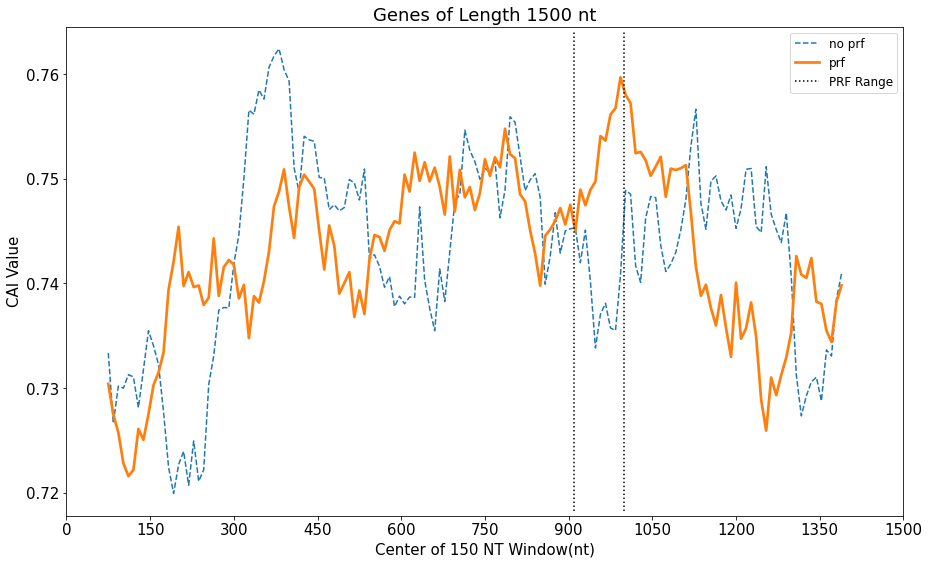

In [53]:
#graph
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 15})
x = np.arange(0,int(short)) * 9 + int(window/2)
plt.figure(figsize = [15,9])
plt.plot(x, cais_noprf_mean[:short], '--',)
plt.plot(x, cais_830_prf_mean[:short], linewidth = 2.718)

plt.axvline(x = int(rang[0]), ymin=0.01, ymax=0.99, color = 'black', linestyle = ':')
plt.axvline(x = int(rang[1]), ymin=0.01, ymax=0.99, color = 'black', linestyle = ':')
plt.title('Genes of Length 1500 nt')

plt.rcParams.update({'font.size': 12})
plt.legend(['no prf', 'prf', 'PRF Range'])
plt.rcParams.update({'font.size': 12})
plt.ylabel('CAI Value')
plt.rcParams.update({'font.size': 10})
plt.xlabel('Center of 150 NT Window(nt)')

plt.xticks(np.arange(0,1501, 150))

In [54]:
(830 - window ) /9


75.55555555555556

In [55]:
(800 - window ) /9

72.22222222222223

In [600]:
(1521 - window ) /9

152.33333333333334

In [601]:
short 

147

# Repeat for some shorter genes

In [75]:
import pandas as pd
window = 150

fastaFile = 'yeast_gencode_all_exons_pcs_IDs_1L_filt.fa'
sequences = {} 
with open(fastaFile, 'r') as g: 
    for line in g: 
        l = line.strip()
        if l.startswith('>'):
            info = l.split(':')
            gene_name = info[-1]
        else: 
            raw_seq = l.upper()
            if 970 < len(raw_seq) < 1030: 
                sequences[gene_name] = adj_for_stop(raw_seq)
inprf = {}
notinprf = {} 
for k in sequences.keys():
    if k in prf_ids:
        inprf[k] = sequences[k]
        
    else: 
        notinprf[k] = sequences[k]
        
rang = prf_range(list(inprf.keys()), id2prfloc, 1000)
rang = rang.split('-')
consider_prfs = [] 
for k in inprf.keys(): 
  
    for p in id2prfloc[k]:
        if int(rang[0])<= p <= int(rang[1]):
            consider_prfs.append(k)
            
            
            break
                     
len(consider_prfs)
window = 150
cais_noprf = {}
pos =[]

for k in notinprf.keys(): 
    seq = sequences[k]
    cais = []
   
    #for i in range(window, len(seq), 9):
    
        #before = seq[(i - window):i]
        
    for i in range(int(window/2), int(len(seq) - window/2) , 9):
        
        before = seq[int(i - window/2): int(i + window/2)]
        cai_before, cost_before = calc_cai_cost(before.upper())
        cais.append(cai_before)
 
      
    cais_noprf[k] = cais
    
cais_830_prf = {}
for k in consider_prfs: 
    seq = sequences[k]
    cais = []
    #for i in range(window, len(seq), 9):

        #before = seq[(i - window):i]
    for i in range(int(window/2), len(seq) - int(window/2) , 9):
        before = seq[int(i - window/2):int(i + window/2)]
        cai_before, cost_before = calc_cai_cost(before.upper())
        cais.append(cai_before)
     
    

    cais_830_prf[k] = cais


long, short = get_longest(cais_noprf,cais_830_prf)
print(long)
cais_830_prf = fill(cais_830_prf, long)
cais_noprf = fill(cais_noprf, long)

df = pd.DataFrame(cais_830_prf)
cais_830_prf_mean = df.mean(axis=1)


df2 = pd.DataFrame(cais_noprf)
cais_noprf_mean = df2.mean(axis=1) 



150-240
153-243
156-246
162-252
165-255
222-312
225-315
231-321
[153, 234, 273, 276, 369]
[285, 504, 69]
[240]
[108, 129, 282, 450]
[189, 234, 471, 69, 72]
[306]
[171, 294, 324]
[243]
[267, 369, 372, 387, 519, 81, 867, 960]
[276, 870]
[321]
[228, 273, 879]
[237]
[252, 471]
[273]
[297, 486, 489]
[285]
[282, 630]
[306, 69]
[309, 360, 726]
[291, 522]
[27, 312]
[321, 852]
[294]
[231, 651, 798, 93]
[132, 240, 726, 864]
[312]
[294, 471]
[321, 360]
[156, 252, 939]
98


([<matplotlib.axis.XTick at 0x7fd720510eb0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

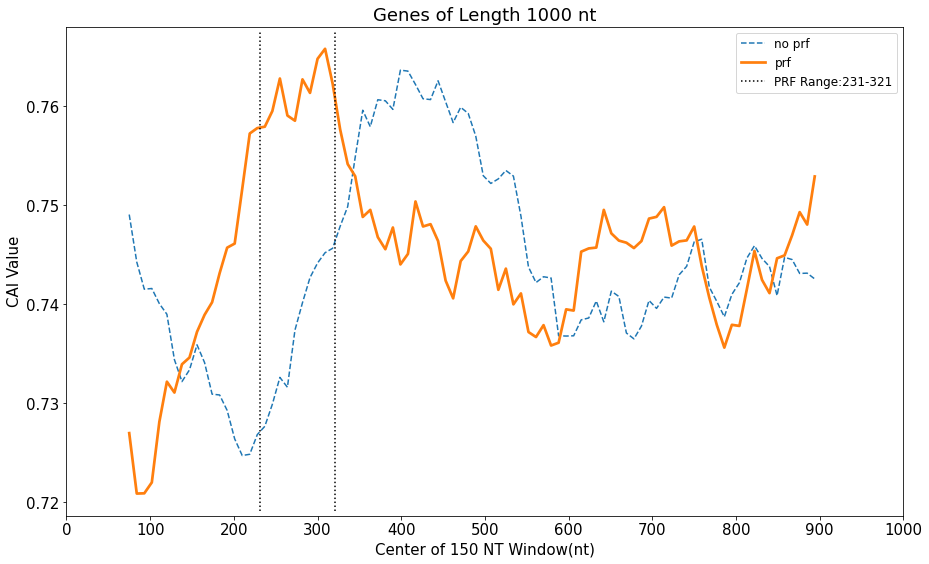

In [36]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 15})
x = np.arange(0,int(short)) * 9 + int(window/2)
plt.figure(figsize = [15,9])
plt.plot(x, cais_noprf_mean[:short], '--',)
plt.plot(x, cais_830_prf_mean[:short], linewidth = 2.718)

plt.axvline(x = int(rang[0]), ymin=0.01, ymax=0.99, color = 'black', linestyle = ':')
plt.axvline(x = int(rang[1]), ymin=0.01, ymax=0.99, color = 'black', linestyle = ':')
plt.title('Genes of Length 1000 nt')

plt.rcParams.update({'font.size': 12})
plt.legend(['no prf', 'prf', 'PRF Range:' + str(rang[0]) + '-' + str(rang[1])])
plt.rcParams.update({'font.size': 12})
plt.ylabel('CAI Value')
plt.rcParams.update({'font.size': 10})
plt.xlabel('Center of 150 NT Window(nt)')

plt.xticks(np.arange(0,1001, 100))

# another one

In [31]:
import pandas as pd
window = 150

fastaFile = 'yeast_gencode_all_exons_pcs_IDs_1L_filt.fa'
sequences = {} 
with open(fastaFile, 'r') as g: 
    for line in g: 
        l = line.strip()
        if l.startswith('>'):
            info = l.split(':')
            gene_name = info[-1]
        else: 
            raw_seq = l.upper()
            if 720 < len(raw_seq) < 780: 
                sequences[gene_name] = adj_for_stop(raw_seq)
inprf = {}
notinprf = {} 
for k in sequences.keys():
    if k in prf_ids:
        inprf[k] = sequences[k]
        
    else: 
        notinprf[k] = sequences[k]
        
rang = prf_range(list(inprf.keys()), id2prfloc, 750)
rang = rang.split('-')
consider_prfs = [] 
for k in inprf.keys(): 
  
    for p in id2prfloc[k]:
        if int(rang[0])<= p <= int(rang[1]):
            consider_prfs.append(k)
            
            print(id2prfloc[k])
            break
                     
len(consider_prfs)
window = 150
cais_noprf = {}
pos =[]

for k in notinprf.keys(): 
    seq = sequences[k]
    cais = []
   
    #for i in range(window, len(seq), 9):
    
        #before = seq[(i - window):i]
        
    for i in range(int(window/2), int(len(seq) - window/2) , 9):
        
        before = seq[int(i - window/2): int(i + window/2)]
        cai_before, cost_before = calc_cai_cost(before.upper())
        cais.append(cai_before)
 
      
    cais_noprf[k] = cais
    
cais_830_prf = {}
for k in consider_prfs: 
    seq = sequences[k]
    cais = []
    #for i in range(window, len(seq), 9):

        #before = seq[(i - window):i]
    for i in range(int(window/2), len(seq) - int(window/2) , 9):
        before = seq[int(i - window/2):int(i + window/2)]
        cai_before, cost_before = calc_cai_cost(before.upper())
        cais.append(cai_before)
     
    

    cais_830_prf[k] = cais


long, short = get_longest(cais_noprf,cais_830_prf)
print(long)
cais_830_prf = fill(cais_830_prf, long)
cais_noprf = fill(cais_noprf, long)

df = pd.DataFrame(cais_830_prf)
cais_830_prf_mean = df.mean(axis=1)


df2 = pd.DataFrame(cais_noprf)
cais_noprf_mean = df2.mean(axis=1) 



[663, 666]
[456, 669]
[201, 45, 621]
[630]
[660]
[156, 237, 648]
[663]
[261, 642]
[690]
[567, 633, 666]
[465, 525, 615]
[624]
[645]
[666]
[696]
[303, 630, 651]
[267, 648]
[231, 621]
[642]
[693]
[684, 72]
[111, 483, 603, 654]
[450, 453, 642]
70


([<matplotlib.axis.XTick at 0x7f8549be57f0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

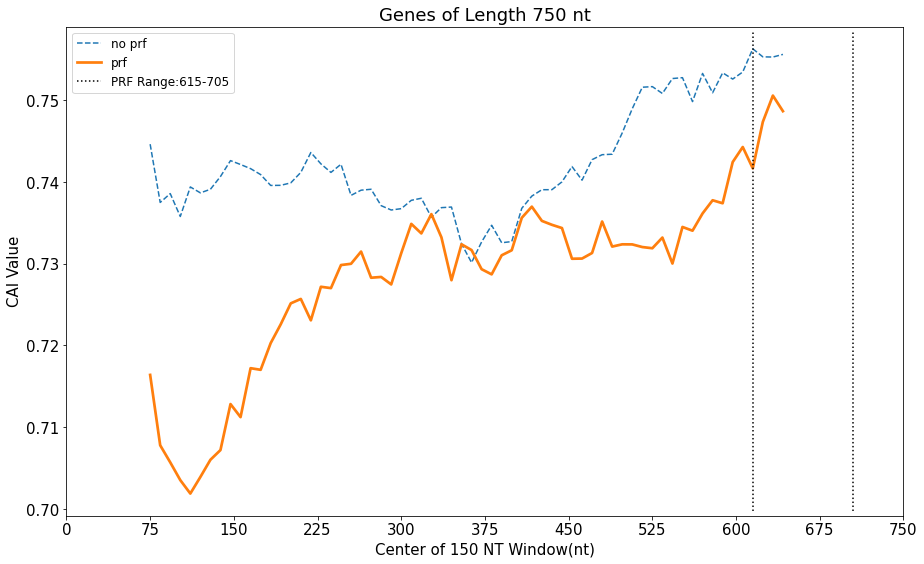

In [32]:
plt.rcParams.update({'font.size': 15})
x = np.arange(0,int(short)) * 9 + int(window/2)
plt.figure(figsize = [15,9])
plt.plot(x, cais_noprf_mean[:short], '--',)
plt.plot(x, cais_830_prf_mean[:short], linewidth = 2.718)

plt.axvline(x = int(rang[0]), ymin=0.01, ymax=0.99, color = 'black', linestyle = ':')
plt.axvline(x = int(rang[1]), ymin=0.01, ymax=0.99, color = 'black', linestyle = ':')
plt.title('Genes of Length 750 nt')

plt.rcParams.update({'font.size': 12})
plt.legend(['no prf', 'prf', 'PRF Range:' + str(rang[0]) + '-' + str(rang[1])])
plt.rcParams.update({'font.size': 12})
plt.ylabel('CAI Value')
plt.rcParams.update({'font.size': 10})
plt.xlabel('Center of 150 NT Window(nt)')

plt.xticks(np.arange(0,751, 75))

In [61]:
consider_prfs

['YAL042W',
 'YDL150W',
 'YDL027C',
 'YDR076W',
 'YDR222W',
 'YDR282C',
 'YDR289C',
 'YDR331W',
 'YDR528W',
 'YGR159C',
 'YIL160C',
 'YIL119C',
 'YJL159W',
 'YJR084W',
 'YKR061W',
 'YLR213C',
 'YLR225C',
 'YMR067C',
 'YMR147W',
 'YMR253C',
 'YNL207W',
 'YNL181W',
 'YNL136W',
 'YNL009W',
 'YOL140W',
 'YOL083W',
 'YOL031C',
 'YOL022C',
 'YOR134W',
 'YOR303W',
 'YPL060W',
 'YPR133C']

In [62]:
notinprf.keys()

dict_keys(['YBR036C', 'YCL052C', 'YCR012W', 'YDR255C', 'YDR432W', 'YDR465C', 'YGL223C', 'YHR033W', 'YIL033C', 'YJL046W', 'YKL219W', 'YKR048C', 'YKR092C', 'YLL057C', 'YLR027C', 'YLR380W', 'YNL309W', 'YNL064C', 'YOL054W', 'YOR042W', 'YPL048W', 'YPR118W'])

## try with costs

In [21]:
a = list(cais_830_prf.keys())
b = list(notinprf.keys())

for g1 in a: 
        
    for g2 in b: 
        if g2 == g1:
            print('Danger') 
            print(g2)
            print(g1)

for g1 in b:     
    for g2 in a: 
        if g2 == g1: 
            print('Danger')

In [47]:
import pandas as pd
window = 150

fastaFile = 'yeast_gencode_all_exons_pcs_IDs_1L_filt.fa'
sequences = {} 
with open(fastaFile, 'r') as g: 
    for line in g: 
        l = line.strip()
        if l.startswith('>'):
            info = l.split(':')
            gene_name = info[-1]
        else: 
            raw_seq = l.upper()
            if 570 <= len(raw_seq) <= 630: 
                sequences[gene_name] = adj_for_stop(raw_seq)
inprf = {}
notinprf = {} 
for k in sequences.keys():
    if k in prf_ids:
        inprf[k] = sequences[k]
        
    else: 
        notinprf[k] = sequences[k]
        
rang = prf_range(list(inprf.keys()), id2prfloc, 600)
rang = rang.split('-')
consider_prfs = [] 

#rang = [350, 450]
for k in inprf.keys(): 
  
    for p in id2prfloc[k]:
        if int(rang[0])<= p <= int(rang[1]):
        #if 350 <= p <= 450:
            consider_prfs.append(k)
            
            print(id2prfloc[k])
            break
                     
len(consider_prfs)
window = 150
cais_noprf = {}
pos =[]

for k in notinprf.keys(): 
    seq = sequences[k]
    cais = []
   
    #for i in range(window, len(seq), 9):
    
        #before = seq[(i - window):i]
        
    for i in range(int(window/2), int(len(seq) - window/2) , 9):
        
        before = seq[int(i - window/2): int(i + window/2)]
        cai_before, cost_before = calc_cai_cost(before.upper())
        cais.append(cost_before)
 
      
    cais_noprf[k] = cais
    
cais_830_prf = {}
for k in consider_prfs: 
    seq = sequences[k]
    cais = []
    #for i in range(window, len(seq), 9):

        #before = seq[(i - window):i]
    for i in range(int(window/2), len(seq) - int(window/2) , 9):
        before = seq[int(i - window/2):int(i + window/2)]
        cai_before, cost_before = calc_cai_cost(before.upper())
        cais.append(cost_before)
     
    

    cais_830_prf[k] = cais


long, short = get_longest(cais_noprf,cais_830_prf)

cais_830_prf = fill(cais_830_prf, long)
cais_noprf = fill(cais_noprf, long)

df = pd.DataFrame(cais_830_prf)
cais_830_prf_mean = df.mean(axis=1)


df2 = pd.DataFrame(cais_noprf)
cais_noprf_mean = df2.mean(axis=1) 



150-240
156-246
[219]
[198, 348]
[228, 78, 81]
[114, 222, 327]
[210]
[15, 183, 33]
[216]
[150, 228]
[18, 240]
[195, 279, 348]
[24, 246, 492, 495]
[159, 453]
[183]
[240, 510]
[204, 225, 228, 372]
[168]
[156]
[240]
[174, 285]
[204]
[150, 213, 429]
[159]
[156, 324, 414, 45]
[129, 132, 177, 213]
[240, 282, 297]
[240, 339, 468, 471]
[162, 174, 309, 486, 558]
[168]
[186, 246, 426]
[24, 246, 492]
[231]
[198, 42]
[159]


([<matplotlib.axis.XTick at 0x7f949298a790>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

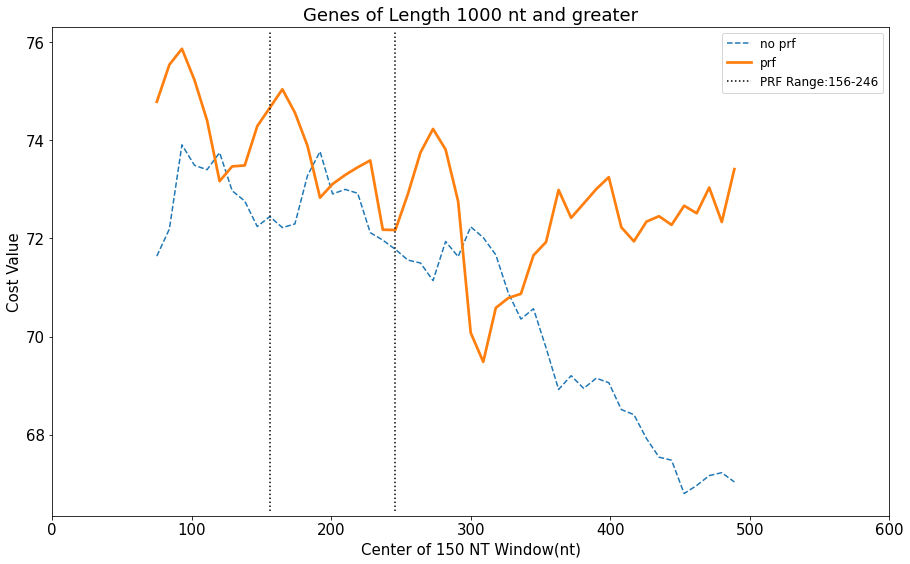

In [49]:
import matplotlib.pyplot as plt

normalized_noprf = cais_noprf_mean[:short] 
normalized_prf = cais_830_prf_mean[:short] 

plt.rcParams.update({'font.size': 15})
x = np.arange(0,int(short)) * 9 + int(window/2)
plt.figure(figsize = [15,9])
plt.plot(x, normalized_noprf, '--',)
plt.plot(x, normalized_prf, linewidth = 2.718)

plt.axvline(x = int(rang[0]), ymin=0.01, ymax=0.99, color = 'black', linestyle = ':')
plt.axvline(x = int(rang[1]), ymin=0.01, ymax=0.99, color = 'black', linestyle = ':')
plt.title('Genes of Length 1000 nt and greater')

plt.rcParams.update({'font.size': 12})
plt.legend(['no prf', 'prf', 'PRF Range:' + str(rang[0]) + '-' + str(rang[1])])
plt.rcParams.update({'font.size': 12})
plt.ylabel('Cost Value')
plt.rcParams.update({'font.size': 10})
plt.xlabel('Center of 150 NT Window(nt)')

plt.xticks(np.arange(0,601, 100))

In [45]:
len(consider_prfs)

33

In [46]:
len(notinprf.keys())

18

In [36]:
elongate_dic

{'GCT': 0.5494505494505495,
 'GCC': 0.8547008547008548,
 'GCA': 1.278772378516624,
 'GCG': 1.278772378516624,
 'CGT': 2.375296912114014,
 'CGC': 3.7037037037037033,
 'CGA': 3.7037037037037033,
 'CGG': 6.410256410256411,
 'AGA': 0.5813953488372093,
 'AGG': 5.813953488372094,
 'AAT': 1.0460251046025104,
 'AAC': 0.641025641025641,
 'GAT': 0.6451612903225806,
 'GAC': 0.39525691699604737,
 'TGT': 2.192982456140351,
 'TGC': 1.3386880856760375,
 'CAA': 0.7092198581560284,
 'CAG': 6.410256410256411,
 'GAA': 0.5434782608695653,
 'GAG': 3.194888178913738,
 'GGT': 0.6060606060606061,
 'GGC': 0.37037037037037035,
 'GGA': 2.1321961620469083,
 'GGG': 3.194888178913738,
 'CAT': 1.1862396204033214,
 'CAC': 0.7246376811594202,
 'ATT': 0.4926108374384236,
 'ATC': 0.7692307692307692,
 'ATA': 3.194888178913738,
 'TTA': 0.9174311926605504,
 'TTG': 0.5208333333333334,
 'CTT': 10.416666666666666,
 'CTC': 6.410256410256411,
 'CTA': 1.1111111111111112,
 'CTG': 1.1111111111111112,
 'AAA': 1.4925373134328357,
 '